# Data Processing

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=False, num_workers=2)

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [8]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

plane   car   car  frog


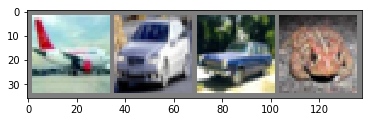

In [9]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Define Convolution Neural Network

In [10]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train Network

In [12]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.221
[1,  4000] loss: 1.928
[1,  6000] loss: 1.736
[1,  8000] loss: 1.605
[1, 10000] loss: 1.533
[1, 12000] loss: 1.472
[2,  2000] loss: 1.406
[2,  4000] loss: 1.394
[2,  6000] loss: 1.344
[2,  8000] loss: 1.322
[2, 10000] loss: 1.290
[2, 12000] loss: 1.281
Finished Training


### Class by class accuracy

In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 58 %
Accuracy of   car : 70 %
Accuracy of  bird : 37 %
Accuracy of   cat : 25 %
Accuracy of  deer : 47 %
Accuracy of   dog : 50 %
Accuracy of  frog : 82 %
Accuracy of horse : 57 %
Accuracy of  ship : 67 %
Accuracy of truck : 62 %


### Entire dataset accuracy

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


# Parallel Dataset Builder

In [20]:
import random

class ParallelSplitter:
    def __init__(self, dataset, num_splits=1, seed=9999):
        # Define split vars
        self.num_splits = num_splits
        random.seed(seed)
        self.indices = list(range(len(dataset)))
        random.shuffle(self.indices)
        self.dataset = dataset
#         data_len = len(dataset)
        
        # Make splits
#         splits = []
        self.split_frac = 1. / float(num_splits)
#         for i in range(self.num_splits):
#             splits.append()

    def __len__(self):
        return self.num_splits
    
    def __getitem__(self, split_num):
        try:
            start = int(len(self.dataset) * self.split_frac * split_num)
            end = int(len(self.dataset) * self.split_frac * (split_num + 1))
            return [self.dataset[i] for i in self.indices[start : end]]
        except IndexError:
            raise IndexError('Index out of bounds')

In [21]:
parallel_splitter = ParallelSplitter(trainset)

In [22]:
for i in range(len(parallel_splitter)):
    print(len(parallel_splitter[i]))

50000


In [23]:
double_split = ParallelSplitter(trainset, 2)

In [25]:
for i in range(len(double_split)):
    print(len(double_split[i]))

25000
25000
